In [1]:
import pandas as pd
import numpy as np
import gc

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Plotting
import matplotlib.pyplot as plt

import seaborn as sns 

## Data Preprocessing

In [2]:
voter_df = pd.read_csv('../data/voter_turnout_merged_all_states.csv')
print("shape: ",voter_df.shape)
voter_df.head()

shape:  (1492, 69)


,Residence_Addresses_City,elec_date,elec_year,elec_type,total_voters_asian,total_voters_black,total_voters_hispanic,total_voters_others,total_voters_white,voted_voters_asian,...,total_voters_college,total_voters_no_college,voted_voters_college,voted_voters_no_college,perc_turnout_college,perc_turnout_no_college,mean_age,voter_population,voted_voters,state
0,Oakland,2020_11_03,2020,General,30600.0,61476.0,37174.0,8628.0,83122,23041.0,...,80668,27989.0,71356,22543.0,88.456389,80.542356,47.829424,331652,172221,CA
1,Oakland,2018_11_06,2018,General,30600.0,61476.0,37174.0,8628.0,83122,14972.0,...,80668,27989.0,59248,17372.0,73.446720,62.067241,48.224196,331652,130249,CA
2,Oakland,2016_11_08,2016,General,30600.0,61476.0,37174.0,8628.0,83122,16057.0,...,80668,27989.0,60766,18951.0,75.328507,67.708743,46.819512,331652,135633,CA
3,Oakland,2014_11_04,2014,General,30600.0,61476.0,37174.0,8628.0,83122,8145.0,...,80668,27989.0,38216,10811.0,47.374424,38.625889,51.034918,331652,75153,CA
4,San Leandro,2020_11_03,2020,General,12705.0,5596.0,16028.0,2429.0,17780,9229.0,...,19051,10653.0,16014,8674.0,84.058580,81.423073,49.752550,70359,41879,CA


In [3]:
print([col for col in voter_df.columns if 'total_voters'  in col])

['total_voters_asian', 'total_voters_black', 'total_voters_hispanic', 'total_voters_others', 'total_voters_white', 'total_voters_$1000-14999', 'total_voters_$100000-124999', 'total_voters_$125000-149999', 'total_voters_$15000-24999', 'total_voters_$150000-174999', 'total_voters_$175000-199999', 'total_voters_$200000-249999', 'total_voters_$25000-34999', 'total_voters_$250000+', 'total_voters_$35000-49999', 'total_voters_$50000-74999', 'total_voters_$75000-99999', 'total_voters_college', 'total_voters_no_college']


In [4]:
voted_voters_cols = [col for col in voter_df.columns if 'voted_voters' in col ]
print(voted_voters_cols)

['voted_voters_asian', 'voted_voters_black', 'voted_voters_hispanic', 'voted_voters_others', 'voted_voters_white', 'voted_voters_$1000-14999', 'voted_voters_$100000-124999', 'voted_voters_$125000-149999', 'voted_voters_$15000-24999', 'voted_voters_$150000-174999', 'voted_voters_$175000-199999', 'voted_voters_$200000-249999', 'voted_voters_$25000-34999', 'voted_voters_$250000+', 'voted_voters_$35000-49999', 'voted_voters_$50000-74999', 'voted_voters_$75000-99999', 'voted_voters_college', 'voted_voters_no_college', 'voted_voters']


In [5]:
#replace all NAN for voted_voters and total_voters counts  with 0

voters_col = [col for col in voter_df.columns if 'voted_voters' in col or 'total_voters'  in col]
voter_df[voters_col] = voter_df[voters_col].fillna(0) 

In [6]:
#double check to make sure the sum adds up
print("num mismatch voted_voters and by race:", sum(voter_df['voted_voters'] != voter_df['voted_voters_asian'] + 
          voter_df['voted_voters_black']+voter_df['voted_voters_hispanic'] + 
          voter_df['voted_voters_others'] + voter_df['voted_voters_white']))

num mismatch voted_voters and by race: 0


In [7]:
# `voter_population` is calculated from census data for people over age 20
# calculate new `total_voters columns` that should be used instead.
voter_df['total_voters'] = voter_df['total_voters_asian'] + voter_df['total_voters_black']+voter_df['total_voters_hispanic'] + voter_df['total_voters_others'] + voter_df['total_voters_white']
print("num mismatch total_voters and voter_population:", sum(voter_df['total_voters'] !=  voter_df['voter_population']))
print("shape of voter_df:", voter_df.shape)


num mismatch total_voters and voter_population: 1492
shape of voter_df: (1492, 70)


In [8]:
voter_df.Residence_Addresses_City.nunique()

213

In [9]:
#adding outcome features for income

voter_df['perc_turnout_under_50k'] = (voter_df['voted_voters_$1000-14999'] + 
                                voter_df['voted_voters_$15000-24999'] + 
                                voter_df['voted_voters_$25000-34999'] + 
                                voter_df['voted_voters_$35000-49999']) / \
                               (voter_df['total_voters_$1000-14999'] + 
                                voter_df['total_voters_$15000-24999'] + 
                                voter_df['total_voters_$25000-34999'] + 
                                voter_df['total_voters_$35000-49999'])
            
voter_df['perc_turnout_over_100k'] = (voter_df['voted_voters_$100000-124999'] + 
                                voter_df['voted_voters_$125000-149999'] + 
                                voter_df['voted_voters_$150000-174999'] +  
                                voter_df['voted_voters_$175000-199999'] + 
                                voter_df['voted_voters_$200000-249999'] + 
                                voter_df['voted_voters_$250000+']) / \
                               (voter_df['total_voters_$100000-124999'] + 
                                voter_df['total_voters_$125000-149999'] + 
                                voter_df['total_voters_$150000-174999'] +  
                                voter_df['total_voters_$175000-199999'] + 
                                voter_df['total_voters_$200000-249999'] + 
                                voter_df['total_voters_$250000+'])

voter_df.head()

,Residence_Addresses_City,elec_date,elec_year,elec_type,total_voters_asian,total_voters_black,total_voters_hispanic,total_voters_others,total_voters_white,voted_voters_asian,...,voted_voters_no_college,perc_turnout_college,perc_turnout_no_college,mean_age,voter_population,voted_voters,state,total_voters,perc_turnout_under_50k,perc_turnout_over_100k
0,Oakland,2020_11_03,2020,General,30600.0,61476.0,37174.0,8628.0,83122,23041.0,...,22543.0,88.456389,80.542356,47.829424,331652,172221,CA,221000.0,0.693252,0.852955
1,Oakland,2018_11_06,2018,General,30600.0,61476.0,37174.0,8628.0,83122,14972.0,...,17372.0,73.446720,62.067241,48.224196,331652,130249,CA,221000.0,0.478709,0.686407
2,Oakland,2016_11_08,2016,General,30600.0,61476.0,37174.0,8628.0,83122,16057.0,...,18951.0,75.328507,67.708743,46.819512,331652,135633,CA,221000.0,0.528991,0.692809
3,Oakland,2014_11_04,2014,General,30600.0,61476.0,37174.0,8628.0,83122,8145.0,...,10811.0,47.374424,38.625889,51.034918,331652,75153,CA,221000.0,0.273848,0.408208
4,San Leandro,2020_11_03,2020,General,12705.0,5596.0,16028.0,2429.0,17780,9229.0,...,8674.0,84.058580,81.423073,49.752550,70359,41879,CA,54538.0,0.770270,0.793565


In [10]:
voter_df[voter_df['perc_turnout_under_50k'].isnull()]

,Residence_Addresses_City,elec_date,elec_year,elec_type,total_voters_asian,total_voters_black,total_voters_hispanic,total_voters_others,total_voters_white,voted_voters_asian,...,voted_voters_no_college,perc_turnout_college,perc_turnout_no_college,mean_age,voter_population,voted_voters,state,total_voters,perc_turnout_under_50k,perc_turnout_over_100k
420,Timonium,2020_11_03,2020,General,1.0,0.0,0.0,0.0,5,1.0,...,0.0,100.0,NaN,62.555699,8343,6,MD,6.0,NaN,1.0
421,Timonium,2018_11_06,2018,General,1.0,0.0,0.0,0.0,5,0.0,...,0.0,0.0,NaN,71.290535,8343,3,MD,6.0,NaN,0.5
422,Timonium,2016_11_08,2016,General,1.0,0.0,0.0,0.0,5,0.0,...,0.0,0.0,NaN,69.297339,8343,3,MD,6.0,NaN,0.5
423,Timonium,2014_11_04,2014,General,1.0,0.0,0.0,0.0,5,0.0,...,0.0,0.0,NaN,67.284977,8343,3,MD,6.0,NaN,0.5
448,North Bethesda,2020_11_03,2020,General,0.0,0.0,1.0,1.0,4,0.0,...,0.0,50.0,NaN,50.697824,39494,3,MD,6.0,NaN,0.6
449,North Bethesda,2018_11_06,2018,General,0.0,0.0,1.0,1.0,4,0.0,...,0.0,100.0,NaN,51.076568,39494,3,MD,6.0,NaN,0.4
450,North Bethesda,2016_11_08,2016,General,0.0,0.0,1.0,1.0,4,0.0,...,0.0,100.0,NaN,49.083372,39494,3,MD,6.0,NaN,0.4
451,North Bethesda,2014_11_04,2014,General,0.0,0.0,1.0,1.0,4,0.0,...,0.0,50.0,NaN,70.884412,39494,1,MD,6.0,NaN,0.2


In [11]:
#drop rows with missing values (these rows look like they have very low turnout anyway)
voter_df.dropna(inplace=True)
#checking rows with missing values
voter_df.columns[voter_df.isna().any()].tolist()

[]

In [12]:
#define RCV and non-rcv cities
rcv_cities = ['Albany', 'Berkeley', 'Eureka', 'Oakland', 'Palm Desert', 'San Francisco', 'San Leandro',
             'Las Cruces', 'Santa Fe', 'Boulder', 'Burlington', 'Portland', 'Takoma Park', 'Bluffdale',
             'Payson', 'Cottonwood Heights', 'Salt Lake City', 'Sandy', 'Midvale', 'Draper', 'Lehi',
             'Springville', 'South Salt Lake', 'Magna', 'Heber', 'Millcreek', 'Riverton', 'St. Louis Park',
             'Bloomington', 'Minneapolis', 'Minnetonka']
non_rcv_cities = list(set(voter_df['Residence_Addresses_City']) - set(rcv_cities))

#function to generate rcv labels
def label_rcv(row):
    if row['Residence_Addresses_City'] in rcv_cities:
        return 1
    else:
        return 0
    
#add rcv label
voter_df['rcv'] = voter_df.apply(lambda row: label_rcv(row), axis=1)

#add turnout column
voter_df['turnout'] = voter_df['voted_voters'] / voter_df['total_voters']


In [13]:
#specify columns to use. Don't want to use data that already has turnout information
# 'FECDonors_TotalDonationsAmount' can be removed since it can be computed using mean_donation and FECDonors_NumberOfDonations
use_cols = ['Residence_Addresses_City', 'state', 'elec_type', 
             'rcv', 'turnout', 'perc_turnout_white', 'mean_age', 'perc_turnout_under_50k',
           'perc_turnout_over_100k']

#filter to usable columns (i.e. columns that do not show turnout)
voter_df = voter_df[use_cols]
voter_df.head()

,Residence_Addresses_City,state,elec_type,rcv,turnout,perc_turnout_white,mean_age,perc_turnout_under_50k,perc_turnout_over_100k
0,Oakland,CA,General,1,0.779281,84.200332,47.829424,0.693252,0.852955
1,Oakland,CA,General,1,0.589362,69.622964,48.224196,0.478709,0.686407
2,Oakland,CA,General,1,0.613724,69.738457,46.819512,0.528991,0.692809
3,Oakland,CA,General,1,0.340059,42.601237,51.034918,0.273848,0.408208
4,San Leandro,CA,General,1,0.767887,82.328459,49.752550,0.770270,0.793565


In [14]:
#checking rows with missing values
voter_df.columns[voter_df.isna().any()].tolist()

[]

In [15]:
print("Total number of rcv cities:", voter_df.groupby(['Residence_Addresses_City', 'state']).ngroups)
print("Number of rcv cities:", voter_df[voter_df['rcv']== 1].groupby(['Residence_Addresses_City', 'state']).ngroups)
print("Number of non rcv cities:", voter_df[voter_df['rcv']== 0].groupby(['Residence_Addresses_City', 'state']).ngroups)

Total number of rcv cities: 204
Number of rcv cities: 29
Number of non rcv cities: 175


In [16]:
#group by city and election type
voter_df = voter_df.groupby(['Residence_Addresses_City', 'elec_type','state'], as_index=False).mean()

#Need both city and state to merge with census data
# df.drop(columns=['Residence_Addresses_City'], inplace=True)

voter_df.head()


,Residence_Addresses_City,elec_type,state,rcv,turnout,perc_turnout_white,mean_age,perc_turnout_under_50k,perc_turnout_over_100k
0,Adelphi,General,MD,0.0,0.455109,51.538988,54.184656,0.474739,0.501815
1,Alamogordo,General,NM,0.0,0.491373,51.930341,57.574886,0.489294,0.554673
2,Alamogordo,Local_or_Municipal,NM,0.0,0.114373,12.804169,61.541445,0.110822,0.138876
3,Alamosa,Consolidated_General,CO,0.0,0.348872,39.124792,56.419342,0.306489,0.432444
4,Alamosa,General,CO,0.0,0.596245,63.335756,51.515875,0.539032,0.687079


In [17]:
#examine data
print(voter_df.shape)
voter_df.describe()

(355, 9)


,rcv,turnout,perc_turnout_white,mean_age,perc_turnout_under_50k,perc_turnout_over_100k
count,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000
mean,0.146479,0.429763,45.615914,53.601228,0.454661,0.460641
std,0.354085,0.201575,20.796904,3.987326,0.209457,0.206921
min,0.000000,0.065370,7.666349,40.656594,0.047074,0.065155
25%,0.000000,0.234395,24.977112,50.799581,0.272259,0.251885
50%,0.000000,0.483349,51.930341,53.327358,0.483298,0.546967
75%,0.000000,0.602780,63.844511,56.634865,0.630545,0.640483
max,1.000000,0.756453,78.641634,63.042398,0.812635,0.774744


In [18]:
print(voter_df.columns[voter_df.isna().any()].tolist())

[]


# Census Data

In [19]:
cities = pd.read_csv('../data/cities.csv', usecols=['state_id', 'RCV', 'city_ascii',  
                                                   'population_proper',
                                                    'race_white', 
                                                    'education_college_or_above',
                                                    'age_median', 
                                                    'income_household_median'])
print(cities.state_id.unique())

CA_cities = pd.read_csv('../data/ca-cities.csv', usecols=['state_id', 'RCV', 'city_ascii', 
                                                          'race_white', 
                                                          'population_proper',
                                                          'education_college_or_above',
                                                          'age_median', 
                                                          'income_household_median'])

cities = pd.concat([cities, CA_cities])
cities = cities.rename(columns = {'RCV': 'rcv', 'city_ascii': 'Residence_Addresses_City',
                                 'state_id': 'state'})
cities['rcv'] = cities['rcv'].fillna(0)

cities.head()



['NM' 'CO' 'VT' 'ME' 'MD' 'UT' 'MN']


,rcv,Residence_Addresses_City,state,population_proper,age_median,income_household_median,education_college_or_above,race_white
0,0.0,Los Alamos,NM,12035,41.7,101399,66.5,84.4
1,0.0,Albuquerque,NM,558545,36.2,49878,34.3,73.6
2,0.0,Rio Rancho,NM,96159,38.1,63180,30.2,79.9
3,0.0,Farmington,NM,45450,32.9,55179,20.2,61.1
4,0.0,North Valley,NM,11999,48.1,50236,28.0,74.9


In [20]:
cities.describe()

,rcv,population_proper,age_median,income_household_median,education_college_or_above,race_white
count,913.000000,9.130000e+02,913.000000,913.000000,913.000000,913.000000
mean,0.033954,5.636355e+04,36.791566,73569.914567,33.390361,68.947426
std,0.181210,1.596584e+05,6.038693,29671.599317,18.023748,21.930579
min,0.000000,3.564000e+03,19.200000,23541.000000,1.800000,3.500000
25%,0.000000,1.548200e+04,33.000000,52136.000000,19.200000,56.100000
50%,0.000000,2.640500e+04,36.600000,67614.000000,31.300000,74.900000
75%,0.000000,5.876600e+04,40.500000,89446.000000,45.000000,86.700000
max,1.000000,3.999759e+06,75.300000,238750.000000,95.300000,98.700000


In [21]:
print(cities.columns.values)
print(cities.shape)


['rcv' 'Residence_Addresses_City' 'state' 'population_proper' 'age_median'
 'income_household_median' 'education_college_or_above' 'race_white']
(913, 8)


In [22]:
def get_cols_model(df, cities_df, target):

    selected_df = df[['rcv', 
                      'state', 
                      'Residence_Addresses_City', 
                      'elec_type',
                      target]]
    selected_df = selected_df.merge(cities, 
                     on = ['Residence_Addresses_City', 'rcv', 'state'], how = 'left')
    
    #one-hot encode categorical cols
    cat_cols = ['elec_type', 'state']

    selected_df = pd.get_dummies(data=selected_df, columns=cat_cols)

    return  selected_df

df_turnout = get_cols_model(voter_df, cities, 'turnout')           
print(df_turnout.shape)
df_turnout.head()

(355, 19)


,rcv,Residence_Addresses_City,turnout,population_proper,age_median,income_household_median,education_college_or_above,race_white,elec_type_Consolidated_General,elec_type_General,elec_type_Local_or_Municipal,state_CA,state_CO,state_MD,state_ME,state_MN,state_NM,state_UT,state_VT
0,0.0,Adelphi,0.455109,15898,33.9,68064,32.3,17.2,0,1,0,0,0,1,0,0,0,0,0
1,0.0,Alamogordo,0.491373,31248,37.0,45531,20.1,79.1,0,1,0,0,0,0,0,0,1,0,0
2,0.0,Alamogordo,0.114373,31248,37.0,45531,20.1,79.1,0,0,1,0,0,0,0,0,1,0,0
3,0.0,Alamosa,0.348872,9871,27.3,32785,25.3,83.4,1,0,0,0,1,0,0,0,0,0,0
4,0.0,Alamosa,0.596245,9871,27.3,32785,25.3,83.4,0,1,0,0,1,0,0,0,0,0,0


In [23]:
df_white_turnout = get_cols_model(voter_df, cities, 'perc_turnout_white') 
df_mean_age = get_cols_model(voter_df, cities, 'mean_age')                      
df_turnout_under_50k = get_cols_model(voter_df, cities, 'perc_turnout_under_50k')                      
df_turnout_over_100k = get_cols_model(voter_df, cities, 'perc_turnout_over_100k')      


# Model Implementation

## 1. Predict turnout

### 1.1 Random Forest

In [24]:
def get_metrics(target, prediction, is_train):
    
    # Mean absolute error (MAE)
    mae = mean_absolute_error(target.values.ravel(), prediction)

    # Mean squared error (MSE)
    mse = mean_squared_error(target.values.ravel(), prediction)

    # R-squared scores
    r2 = r2_score(target.values.ravel(), prediction)
    
    df = pd.DataFrame([['Mean_Absolute_Error', mae], ['Mean_Squared_Error', mse], ['R_squared_score', r2]])
    
    if is_train == True:
        print("Train")
        df.columns = ['metric', 'rf_train']
    elif is_train ==False:
        print("\nTest")
        df.columns = ['metric', 'rf_test']
        
    # Print metrics
    print('Mean Absolute Error:', round(mae, 3))
    print('Mean Squared Error:', round(mse, 3))
    print('R-squared scores:', round(r2, 3))
    
    return df

#function to generate and print ordered list of feature importance scores
def ordered_feature_importance(features, feature_importances, n=10):
    features = list(features)
    feature_importance = list(feature_importances)
    
    zipped = zip(features, feature_importance)
    sorted_zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
    
    unzipped = list(zip(*sorted_zipped))
    sorted_features = list(unzipped[0])
    sorted_feature_importance = list(unzipped[1])

    for i in range(n):
        print('Feature {} ({}) importance: {}'.format(i, sorted_features[i], sorted_feature_importance[i]))
    
    return sorted_features, sorted_feature_importance

def plot_feature_importance(importance,names,fig_title, file_name):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(fig_title)
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.tight_layout()
    plt.savefig(f'../data/plots/{file_name}.jpg')

rng = np.random.RandomState(0)

def train(df, target):
    print(target)
    # split the data in 80:20 for train:test dataset
    train_size=0.8
    rng = np.random.RandomState(0)

    X = df.drop(columns=[target,'Residence_Addresses_City'])
    y = df[target]

    # In the first step we will split the data in training and remaining dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        train_size=0.8, 
                                                        random_state=rng)
    
    del X, y
    print("train:", X_train.shape, y_train.shape)
    print("test:", X_test.shape, y_test.shape)
    
    #implement random forest
    tuned_parameters = {'n_estimators': [10, 50, 100], 
                        'max_depth': [None, 2, 3], 
                        'max_features': [4, 8, 16, 20, 24]}

    model = GridSearchCV(RandomForestRegressor(bootstrap = True, 
                                               random_state = rng), 
                                 tuned_parameters, 
                                 cv=5, 
                                 n_jobs=-1, 
                                 verbose=1)

    model.fit(X_train, y_train)
    model.score(X_train, y_train)
    best_params = model.best_params_ 
    print("\nBest params after cv:", best_params,'\n')
    
    del model

    best_model = RandomForestRegressor(bootstrap = True, 
                                       random_state = rng, 
                                       max_depth= best_params['max_depth'], 
                                       max_features= best_params['max_features'], 
                                       n_estimators = best_params['n_estimators'])

    best_model.fit(X_train, y_train)

    train_pred = best_model.predict(X_train)
    test_pred = best_model.predict(X_test)
    
    del X_test
    rf_train_metric = get_metrics(y_train, 
                                   train_pred, 
                                   is_train = True)
    rf_test_metric = get_metrics(y_test, 
                                  test_pred, 
                                  is_train = False)
    combine_metric = pd.merge(rf_train_metric, 
                              rf_test_metric, on = "metric")
    print(combine_metric)
    
    del y_train, y_test, train_pred, test_pred
    #del rf_overall_train. rf_overall_test
    
    print('\n')
    sorted_features, sorted_feature_importance = ordered_feature_importance(X_train.columns, 
                                                                            best_model.feature_importances_, 
                                                                            n=len(X_train.columns))
    plot_feature_importance(best_model.feature_importances_, 
                            X_train.columns,
                            fig_title = f'Random Forest feature importance for {target}', 
                            file_name = f'RF_feature_imp_supervised_{target}')                                                     
    del best_model
    return best_params, combine_metric

turnout
train: (284, 17) (284,)
test: (71, 17) (71,)
Fitting 5 folds for each of 45 candidates, totalling 225 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.92449309 0.92906119 0.93123719 0.92832014 0.93585903 0.93530461
 0.92733164 0.93178583 0.93213588        nan        nan        nan
        nan        nan        nan 0.80508638 0.70477658 0.68819526
 0.8510629  0.84970488 0.85086883 0.86903239 0.86707768 0.86791465
        nan        nan        nan        nan        nan        nan
 0.85817545 0.80848433 0.80736352 0.88860533 0.89407771 0.89437462
 0.89564507 0.89878002 0.90002556        nan        nan        nan
        nan        nan        nan]
  warnings.warn(



Best params after cv: {'max_depth': None, 'max_features': 8, 'n_estimators': 50} 

Train
Mean Absolute Error: 0.014
Mean Squared Error: 0.0
R-squared scores: 0.991

Test
Mean Absolute Error: 0.044
Mean Squared Error: 0.003
R-squared scores: 0.926
                metric  rf_train   rf_test
0  Mean_Absolute_Error  0.014282  0.044013
1   Mean_Squared_Error  0.000345  0.003174
2      R_squared_score  0.991334  0.926169


Feature 0 (elec_type_General) importance: 0.4909407245836028
Feature 1 (elec_type_Consolidated_General) importance: 0.1698425191498233
Feature 2 (elec_type_Local_or_Municipal) importance: 0.12316246474875384
Feature 3 (education_college_or_above) importance: 0.05108434103350776
Feature 4 (state_CO) importance: 0.03453217753987014
Feature 5 (race_white) importance: 0.032573571009247994
Feature 6 (income_household_median) importance: 0.022830145589524013
Feature 7 (age_median) importance: 0.020418037589634393
Feature 8 (state_MN) importance: 0.02034794494185319
Feature 9 (p

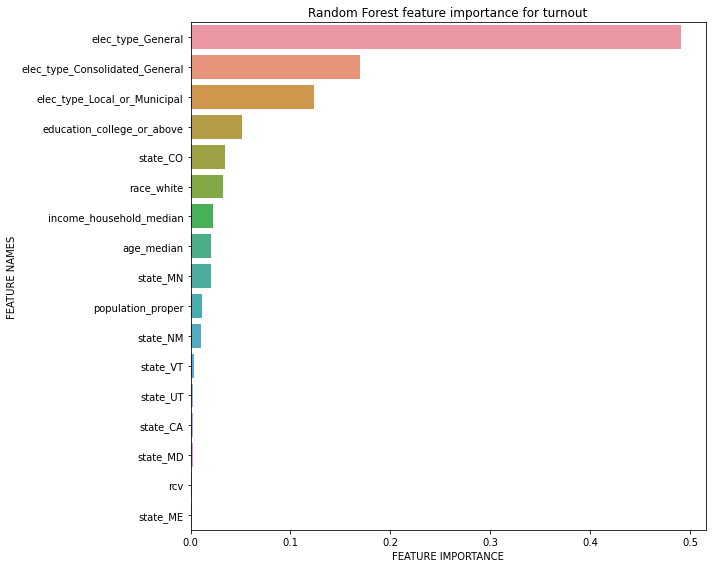

In [25]:
best_params_turnout, rf_metric_turnout = train(df_turnout, 'turnout')

In [26]:
print(best_params_turnout)
print(rf_metric_turnout)

{'max_depth': None, 'max_features': 8, 'n_estimators': 50}
                metric  rf_train   rf_test
0  Mean_Absolute_Error  0.014282  0.044013
1   Mean_Squared_Error  0.000345  0.003174
2      R_squared_score  0.991334  0.926169


### feature importance for RCV and Non RCV 


#### RCV

Target:  turnout

 RCV Cross Validation
df shape: (52, 16) (52,)
Cross validation Mean Absolute Error score: 0.052
Cross validation Mean Squared Error score: 0.005
Cross validation R-sqaured score: 0.869

                 metric  rf_rcv_cv_turnout
0  Mean_Absolute_Error              0.052
1   Mean_Squared_Error              0.005
2      R_squared_score              0.869 

Feature 0 (elec_type_General) importance: 0.5622484175731742
Feature 1 (elec_type_Consolidated_General) importance: 0.229480455491675
Feature 2 (elec_type_Local_or_Municipal) importance: 0.03920850919619944
Feature 3 (income_household_median) importance: 0.038735877805469415
Feature 4 (education_college_or_above) importance: 0.03610041291717802
Feature 5 (age_median) importance: 0.024292579885581037
Feature 6 (race_white) importance: 0.020570299435276492
Feature 7 (population_proper) importance: 0.015847187717274794
Feature 8 (state_MN) importance: 0.01304875660103041
Feature 9 (state_CO) importance: 0.00628493563308

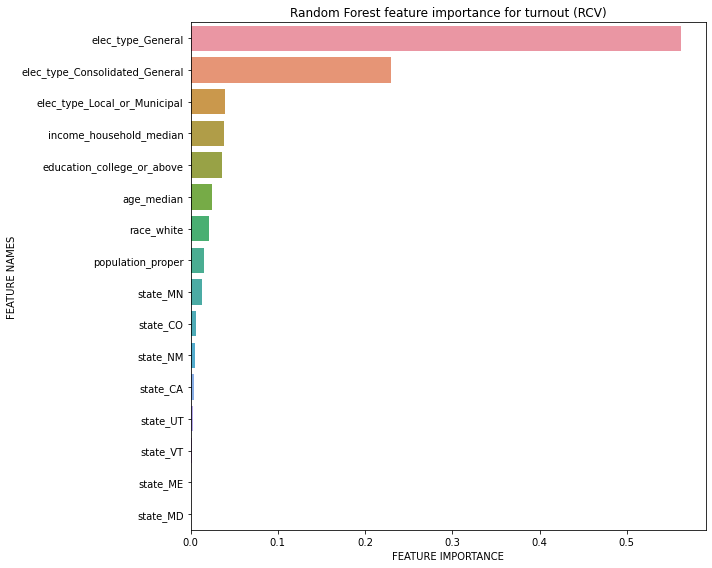

In [27]:
#implement random forest rcv
def get_metrics_CV(model, data, target):
    mae = -round(np.mean(cross_val_score(model, data, target, 
                                   scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)), 3)
    mse = -round(np.mean(cross_val_score(model, data, target, 
                                   scoring='neg_mean_squared_error', cv=10, n_jobs=-1)), 3)
    r2 = round(np.mean(cross_val_score(model, data, target, 
                                  scoring='r2', cv=10, n_jobs=-1)), 3)
    
    print("Cross validation Mean Absolute Error score:", mae)
    print("Cross validation Mean Squared Error score:", mse)
    print("Cross validation R-sqaured score:", r2)
    return pd.DataFrame([['Mean_Absolute_Error', mae], ['Mean_Squared_Error', mse], ['R_squared_score', r2]])

def rf_rcv_nonrcv(df, is_rcv, target, best_params):
    print("Target: ", target)
    
    if is_rcv == True:
        rcv_df = df[df['rcv'] == 1]
        print("\n RCV Cross Validation")
        plot_title = 'Random Forest feature importance for turnout (RCV)'
        fig_save_name = 'RF_feature_imp_RCV'
    elif is_rcv == False:
        rcv_df = df[df['rcv'] == 0]
        print("\n Non RCV Cross Validation")
        plot_title = 'Random Forest feature importance for turnout (Non-RCV)'
        fig_save_name = 'RF_feature_imp_Non_RCV'
        
    rcv_y = rcv_df[target]
    rcv_X = rcv_df.drop(columns=[target, 'rcv','Residence_Addresses_City'])
    print("df shape:", rcv_X.shape, rcv_y.shape)

    rcv_rf = RandomForestRegressor(bootstrap = True, 
                                   oob_score = True, 
                                   random_state = 0, 
                                   max_depth= best_params['max_depth'], 
                                   max_features= best_params['max_features'], 
                                   n_estimators = best_params['n_estimators'])
    rcv_rf.fit(rcv_X, rcv_y)
    rcv_pred = rcv_rf.predict(rcv_X)
    rf_rcv_cv = get_metrics_CV(rcv_rf, rcv_X, rcv_y)
    
    
    if is_rcv == True:
        rf_rcv_cv.columns = ['metric', f'rf_rcv_cv_{target}']
    elif is_rcv == False:
        rf_rcv_cv.columns = ['metric', f'rf_nonrcv_cv_{target}']
        
    print("\n", rf_rcv_cv,"\n")
    
    #generate and print ordered list of feature importance scores
    rf_sorted_features, rf_sorted_feature_importance = ordered_feature_importance(rcv_X.columns, 
                                                                                  rcv_rf.feature_importances_, 
                                                                                  n=len(rcv_X.columns))
                                          
    plot_feature_importance(rcv_rf.feature_importances_, 
                            rcv_X.columns, 
                        fig_title = plot_title, 
                        file_name = fig_save_name)
                                                       
    return rf_rcv_cv, rf_sorted_features, rf_sorted_feature_importance

rf_rcv_turnout, rcv_features_turnout, rcv_feature_importance_turnout = rf_rcv_nonrcv(df_turnout, 
                                                                                     is_rcv = True, 
                                                                                     target = 'turnout', 
                                                                                     best_params =  best_params_turnout)

#### Non-RCV

Target:  turnout

 Non RCV Cross Validation
df shape: (303, 16) (303,)
Cross validation Mean Absolute Error score: 0.039
Cross validation Mean Squared Error score: 0.002
Cross validation R-sqaured score: 0.938

                 metric  rf_nonrcv_cv_turnout
0  Mean_Absolute_Error                 0.039
1   Mean_Squared_Error                 0.002
2      R_squared_score                 0.938 

Feature 0 (elec_type_General) importance: 0.5480350133165248
Feature 1 (elec_type_Consolidated_General) importance: 0.15315475715693688
Feature 2 (elec_type_Local_or_Municipal) importance: 0.08701971204165204
Feature 3 (education_college_or_above) importance: 0.05052807781100811
Feature 4 (state_CO) importance: 0.036781049408692965
Feature 5 (age_median) importance: 0.03109324151940541
Feature 6 (race_white) importance: 0.030715411385349375
Feature 7 (state_MN) importance: 0.014986247151471763
Feature 8 (income_household_median) importance: 0.014868808052417937
Feature 9 (state_NM) importance: 0.013

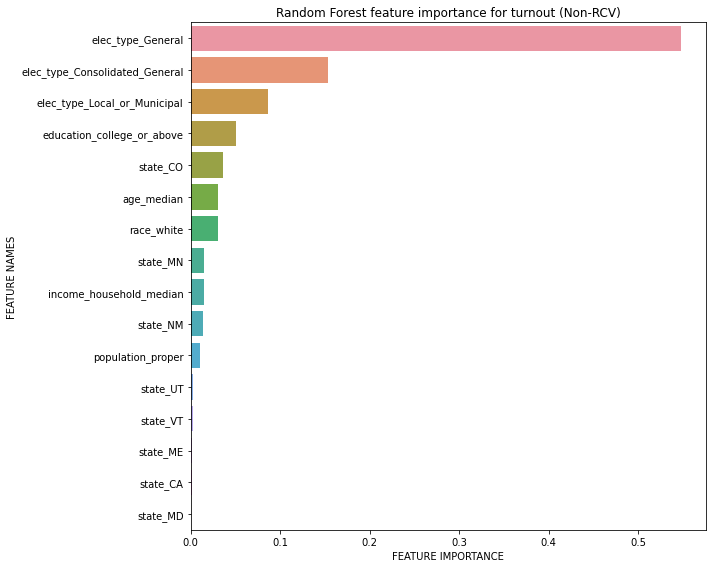

In [28]:
rf_nonrcv_turnout, non_rcv_features_turnout, non_rcv_feature_importance_turnout = rf_rcv_nonrcv(df_turnout, 
                                  is_rcv = False, 
                                  target = 'turnout', 
                                  best_params = best_params_turnout)

#### RCV vs. Non-RCV

In [29]:
nonrcv_df_turnout = pd.DataFrame({'feature': non_rcv_features_turnout, 
                              'importance_nonrcv': non_rcv_feature_importance_turnout})
rcv_df_turnout = pd.DataFrame({'feature': rcv_features_turnout, 
                       'importance_rcv': rcv_feature_importance_turnout})
rcv_df_turnout.merge(nonrcv_df_turnout, right_index = True, left_index = True)

,feature_x,importance_rcv,feature_y,importance_nonrcv
0,elec_type_General,0.562248,elec_type_General,0.548035
1,elec_type_Consolidated_General,0.229480,elec_type_Consolidated_General,0.153155
2,elec_type_Local_or_Municipal,0.039209,elec_type_Local_or_Municipal,0.087020
3,income_household_median,0.038736,education_college_or_above,0.050528
4,education_college_or_above,0.036100,state_CO,0.036781
5,age_median,0.024293,age_median,0.031093
6,race_white,0.020570,race_white,0.030715
7,population_proper,0.015847,state_MN,0.014986
8,state_MN,0.013049,income_household_median,0.014869
9,state_CO,0.006285,state_NM,0.013368


                          feature  importance_nonrcv  importance_rcv
0               elec_type_General           0.548035        0.562248
1  elec_type_Consolidated_General           0.153155        0.229480
2    elec_type_Local_or_Municipal           0.087020        0.039209
3      education_college_or_above           0.050528        0.036100
4                        state_CO           0.036781        0.006285
                          feature           variable     value
0               elec_type_General  importance_nonrcv  0.548035
1  elec_type_Consolidated_General  importance_nonrcv  0.153155
2    elec_type_Local_or_Municipal  importance_nonrcv  0.087020
3      education_college_or_above  importance_nonrcv  0.050528
4                        state_CO  importance_nonrcv  0.036781


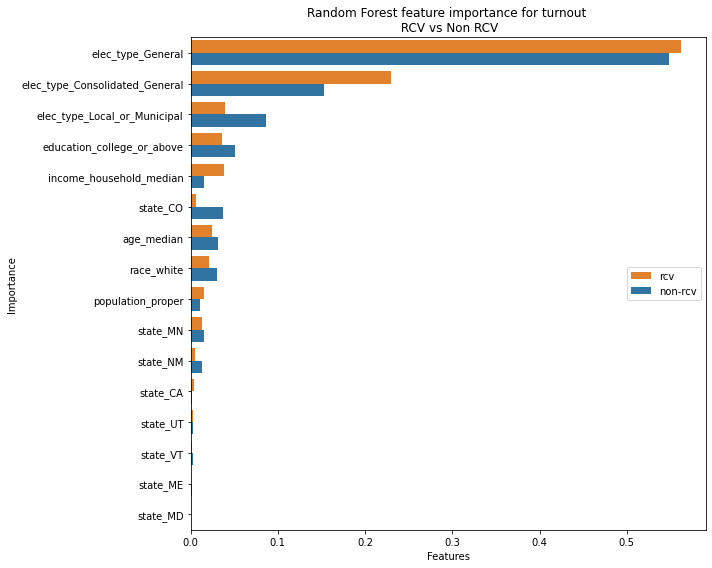

In [30]:
#Match features
def plot_importance_rcv_nonrcv(nonrcv_df, rcv_df):
    
    rcv_v_nonrcv_df = nonrcv_df.merge(rcv_df, on = "feature")
    print(rcv_v_nonrcv_df.head())
    
    rcv_v_nonrcv_df = pd.melt(rcv_v_nonrcv_df, id_vars=['feature'], value_vars=['importance_nonrcv','importance_rcv'])
    print(rcv_v_nonrcv_df.head())
    
    #Create arrays from feature importance and feature names
    variable = np.array(rcv_v_nonrcv_df['variable'])
    value = np.array(rcv_v_nonrcv_df['value'])
    feature_names = np.array(rcv_v_nonrcv_df['feature'])

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'variable':variable,'value':value}
    fi_df = pd.DataFrame(data)
    fi_df = fi_df.replace({'importance_nonrcv': 'non-rcv', 'importance_rcv': 'rcv'})

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['value'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    palette ={"non-rcv": "C0", "rcv": "C1"}

    sns.barplot(x=fi_df['value'], y=fi_df['feature_names'], hue = fi_df['variable'], palette=palette)

    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Random Forest feature importance for turnout \n RCV vs Non RCV')
    plt.legend(loc='center right')
    plt.tight_layout()
    plt.savefig(f'../data/plots/RF_feature_imp_RCV_vs_Non_RCV.jpg')

    
plot_importance_rcv_nonrcv(nonrcv_df_turnout, rcv_df_turnout)
    

In [31]:
del rcv_df_turnout, nonrcv_df_turnout
gc.collect()

14092

### 1.1 Linear Regression

In [32]:
# importing modules and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


In [33]:
df_turnout.head()

,rcv,Residence_Addresses_City,turnout,population_proper,age_median,income_household_median,education_college_or_above,race_white,elec_type_Consolidated_General,elec_type_General,elec_type_Local_or_Municipal,state_CA,state_CO,state_MD,state_ME,state_MN,state_NM,state_UT,state_VT
0,0.0,Adelphi,0.455109,15898,33.9,68064,32.3,17.2,0,1,0,0,0,1,0,0,0,0,0
1,0.0,Alamogordo,0.491373,31248,37.0,45531,20.1,79.1,0,1,0,0,0,0,0,0,1,0,0
2,0.0,Alamogordo,0.114373,31248,37.0,45531,20.1,79.1,0,0,1,0,0,0,0,0,1,0,0
3,0.0,Alamosa,0.348872,9871,27.3,32785,25.3,83.4,1,0,0,0,1,0,0,0,0,0,0
4,0.0,Alamosa,0.596245,9871,27.3,32785,25.3,83.4,0,1,0,0,1,0,0,0,0,0,0


In [34]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats


def train_lrg_sm(df, target):
    X = df.drop(columns=[target,'Residence_Addresses_City'])
    y = df[target]
    # In the first step we will split the data in training and remaining dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        train_size=0.8, 
                                                        random_state=rng)
    num_cols = [col for col in X.columns if col in ['population_proper',
                                                 'age_median',
                                                 'income_household_median',
                                                 'education_college_or_above', 
                                                 'race_white']]
    
    ct = ColumnTransformer([
            ('somename', StandardScaler(), num_cols)
        ], remainder='passthrough')

    ct.fit(X_train)
    
    scaled_X_train = pd.DataFrame(ct.transform(X_train), 
                                  columns = X_train.columns)
    scaled_X_test = pd.DataFrame(ct.transform(X_test), 
                                 columns = X_test.columns)
    print(scaled_X_train.shape)
    print(y_train.shape)
    train_X2 = sm.add_constant(scaled_X_train)
    test_X2 = sm.add_constant(scaled_X_test)
    est = sm.OLS(list(y_train), train_X2)
    est2 = est.fit()
    
    print(est2.summary())
    
    train_pred = est2.predict(train_X2)
    test_pred = est2.predict(test_X2)

    del est, est2, ct 
    
    print("Train")
    linreg_train_metric = get_metrics(y_train, train_pred, is_train =True)
    linreg_train_metric.columns = ['metric', 'linreg_train']

    print("Test")
    linreg_test_metric = get_metrics(y_test, test_pred, is_train =False)
    linreg_test_metric.columns = ['metric', 'linreg_test']
    
    combine_metric = pd.merge(linreg_train_metric, 
                              linreg_test_metric, on = "metric")
    
    return combine_metric

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [35]:
linreg_metric_turnout = train_lrg_sm(df_turnout, 'turnout') 
linreg_metric_turnout

(284, 17)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     194.5
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          2.12e-134
Time:                        16:22:55   Log-Likelihood:                 406.13
No. Observations:                 284   AIC:                            -780.3
Df Residuals:                     268   BIC:                            -721.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.046055,0.043991
1,Mean_Squared_Error,0.003353,0.003380
2,R_squared_score,0.915874,0.921385


### Compare Random Forest and Linear Regression

In [36]:
pd.merge(rf_metric_turnout, linreg_metric_turnout, on = "metric")


,metric,rf_train,rf_test,linreg_train,linreg_test
0,Mean_Absolute_Error,0.014282,0.044013,0.046055,0.043991
1,Mean_Squared_Error,0.000345,0.003174,0.003353,0.003380
2,R_squared_score,0.991334,0.926169,0.915874,0.921385


### Fine Tune Linear Regression

delete one variable at a time using the highest p-value if it is above 0.05

In [37]:
df_turnout.drop(columns = 'state_VT', inplace= True)
train_lrg_sm(df_turnout, 'turnout') 

(284, 16)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     198.7
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.58e-135
Time:                        16:22:55   Log-Likelihood:                 408.74
No. Observations:                 284   AIC:                            -785.5
Df Residuals:                     268   BIC:                            -727.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.045826,0.048479
1,Mean_Squared_Error,0.003292,0.003706
2,R_squared_score,0.917494,0.911087


In [38]:
df_turnout.drop(columns = 'state_MD', inplace= True)
train_lrg_sm(df_turnout, 'turnout') 


(284, 15)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     203.7
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          3.65e-134
Time:                        16:22:55   Log-Likelihood:                 402.17
No. Observations:                 284   AIC:                            -774.3
Df Residuals:                     269   BIC:                            -719.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.046143,0.045561
1,Mean_Squared_Error,0.003448,0.003063
2,R_squared_score,0.913819,0.927379


In [39]:
df_turnout.drop(columns = 'state_ME', inplace= True)
train_lrg_sm(df_turnout, 'turnout') 

(284, 14)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     224.8
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.92e-136
Time:                        16:22:56   Log-Likelihood:                 405.96
No. Observations:                 284   AIC:                            -783.9
Df Residuals:                     270   BIC:                            -732.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.045469,0.049328
1,Mean_Squared_Error,0.003357,0.003435
2,R_squared_score,0.915424,0.920870


In [40]:
df_turnout.drop(columns = 'rcv', inplace= True)
train_lrg_sm(df_turnout, 'turnout') 

(284, 13)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     261.0
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          3.61e-141
Time:                        16:22:56   Log-Likelihood:                 411.41
No. Observations:                 284   AIC:                            -796.8
Df Residuals:                     271   BIC:                            -749.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.044365,0.050500
1,Mean_Squared_Error,0.003231,0.004089
2,R_squared_score,0.920353,0.897249


In [41]:
df_turnout.drop(columns = 'state_CA', inplace= True)
train_lrg_sm(df_turnout, 'turnout') 

(284, 12)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     291.3
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.85e-143
Time:                        16:22:56   Log-Likelihood:                 411.19
No. Observations:                 284   AIC:                            -798.4
Df Residuals:                     272   BIC:                            -754.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.044954,0.052708
1,Mean_Squared_Error,0.003235,0.004064
2,R_squared_score,0.921764,0.888890


In [42]:
df_turnout.drop(columns = 'income_household_median', inplace= True)
train_lrg_sm(df_turnout, 'turnout') 

(284, 11)
(284,)


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     296.9
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          2.19e-140
Time:                        16:22:56   Log-Likelihood:                 405.73
No. Observations:                 284   AIC:                            -789.5
Df Residuals:                     273   BIC:                            -749.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.045512,0.045994
1,Mean_Squared_Error,0.003362,0.003608
2,R_squared_score,0.915806,0.915698


In [43]:
df_turnout.drop(columns = 'population_proper', inplace= True)
train_lrg_sm(df_turnout, 'turnout') 

(284, 10)
(284,)


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     363.4
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          9.83e-147
Time:                        16:22:56   Log-Likelihood:                 414.99
No. Observations:                 284   AIC:                            -810.0
Df Residuals:                     274   BIC:                            -773.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.043902,0.053941
1,Mean_Squared_Error,0.003150,0.004778
2,R_squared_score,0.922706,0.879139


## 2. predict White Share of Voters

In [44]:
df_white_turnout = get_cols_model(voter_df, cities, 'perc_turnout_white') 

df_white_turnout.head()            
                      

,rcv,Residence_Addresses_City,perc_turnout_white,population_proper,age_median,income_household_median,education_college_or_above,race_white,elec_type_Consolidated_General,elec_type_General,elec_type_Local_or_Municipal,state_CA,state_CO,state_MD,state_ME,state_MN,state_NM,state_UT,state_VT
0,0.0,Adelphi,51.538988,15898,33.9,68064,32.3,17.2,0,1,0,0,0,1,0,0,0,0,0
1,0.0,Alamogordo,51.930341,31248,37.0,45531,20.1,79.1,0,1,0,0,0,0,0,0,1,0,0
2,0.0,Alamogordo,12.804169,31248,37.0,45531,20.1,79.1,0,0,1,0,0,0,0,0,1,0,0
3,0.0,Alamosa,39.124792,9871,27.3,32785,25.3,83.4,1,0,0,0,1,0,0,0,0,0,0
4,0.0,Alamosa,63.335756,9871,27.3,32785,25.3,83.4,0,1,0,0,1,0,0,0,0,0,0


### 2.1 Random Forest Linear Regression

perc_turnout_white
train: (284, 17) (284,)
test: (71, 17) (71,)
Fitting 5 folds for each of 45 candidates, totalling 225 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.91879387 0.92598158 0.92698594 0.92735942 0.93306453 0.93411403
 0.9220689  0.92834903 0.9288249         nan        nan        nan
        nan        nan        nan 0.81206283 0.71667168 0.69552436
 0.86245141 0.86027146 0.86329196 0.88555485 0.88597974 0.88591377
        nan        nan        nan        nan        nan        nan
 0.87050342 0.81962677 0.81477322 0.90315696 0.90386854 0.90321979
 0.9060217  0.90799163 0.90825631        nan        nan        nan
        nan        nan        nan]
  warnings.warn(



Best params after cv: {'max_depth': None, 'max_features': 8, 'n_estimators': 100} 

Train
Mean Absolute Error: 1.478
Mean Squared Error: 3.654
R-squared scores: 0.991

Test
Mean Absolute Error: 4.245
Mean Squared Error: 30.986
R-squared scores: 0.931
                metric  rf_train    rf_test
0  Mean_Absolute_Error  1.477980   4.245318
1   Mean_Squared_Error  3.653700  30.986180
2      R_squared_score  0.991421   0.931279


Feature 0 (elec_type_General) importance: 0.5060328826500767
Feature 1 (elec_type_Consolidated_General) importance: 0.1969664507258639
Feature 2 (elec_type_Local_or_Municipal) importance: 0.10480630158610482
Feature 3 (state_CO) importance: 0.038356688477702516
Feature 4 (education_college_or_above) importance: 0.035112550913948944
Feature 5 (age_median) importance: 0.02273997327993769
Feature 6 (income_household_median) importance: 0.020801817547592152
Feature 7 (race_white) importance: 0.020789825394613538
Feature 8 (state_MN) importance: 0.020370524424997694
Fe

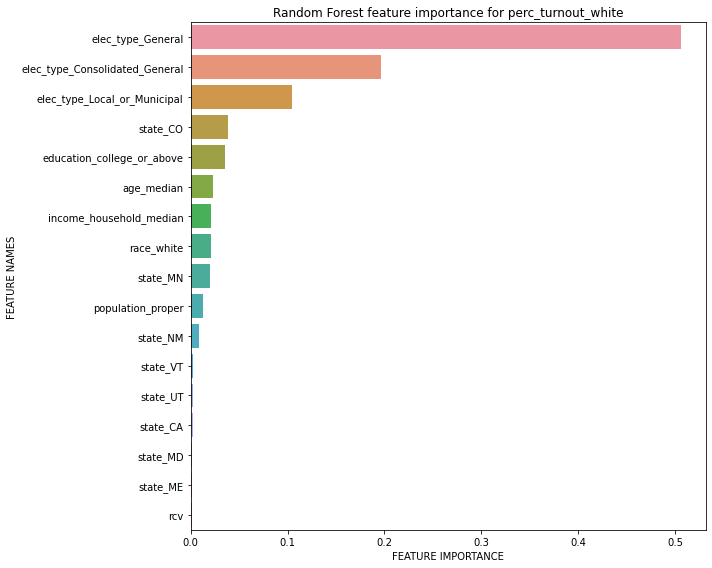

In [45]:
best_params_white_turnout = train(df_white_turnout, 'perc_turnout_white')
print(best_params_white_turnout)

### 2.1 Linear Regressionression

In [46]:
train_lrg_sm(df_white_turnout, 'perc_turnout_white') 

(284, 17)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     206.5
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.41e-137
Time:                        16:23:06   Log-Likelihood:                -910.55
No. Observations:                 284   AIC:                             1853.
Df Residuals:                     268   BIC:                             1911.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,4.716927,5.542291
1,Mean_Squared_Error,35.674960,48.378108
2,R_squared_score,0.920362,0.863191


In [47]:
df_white_turnout.drop(columns = 'state_MD', inplace= True)
train_lrg_sm(df_white_turnout, 'perc_turnout_white') 

(284, 16)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     188.3
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.10e-132
Time:                        16:23:06   Log-Likelihood:                -921.26
No. Observations:                 284   AIC:                             1875.
Df Residuals:                     268   BIC:                             1933.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,4.959898,4.842165
1,Mean_Squared_Error,38.470671,38.996820
2,R_squared_score,0.913344,0.897508


In [48]:
df_white_turnout.drop(columns = 'state_NM', inplace= True)
train_lrg_sm(df_white_turnout, 'perc_turnout_white') 

(284, 15)
(284,)


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     196.6
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          2.81e-132
Time:                        16:23:06   Log-Likelihood:                -915.32
No. Observations:                 284   AIC:                             1861.
Df Residuals:                     269   BIC:                             1915.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,4.809616,5.438997
1,Mean_Squared_Error,36.893103,47.541343
2,R_squared_score,0.910978,0.899435


In [49]:
df_white_turnout.drop(columns = 'age_median', inplace= True)
train_lrg_sm(df_white_turnout, 'perc_turnout_white') 

(284, 14)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     182.9
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.60e-125
Time:                        16:23:06   Log-Likelihood:                -941.21
No. Observations:                 284   AIC:                             1910.
Df Residuals:                     270   BIC:                             1961.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,5.219953,4.829320
1,Mean_Squared_Error,44.271521,35.633917
2,R_squared_score,0.898027,0.912950


In [50]:
df_white_turnout.drop(columns = 'population_proper', inplace= True)
train_lrg_sm(df_white_turnout, 'perc_turnout_white') 

(284, 13)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     206.4
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.21e-128
Time:                        16:23:07   Log-Likelihood:                -939.53
No. Observations:                 284   AIC:                             1905.
Df Residuals:                     271   BIC:                             1952.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,5.173853,4.706838
1,Mean_Squared_Error,43.751238,38.763844
2,R_squared_score,0.901388,0.898401


In [51]:
df_white_turnout.drop(columns = 'rcv', inplace= True)
train_lrg_sm(df_white_turnout, 'perc_turnout_white') 

(284, 12)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     231.9
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          3.48e-131
Time:                        16:23:07   Log-Likelihood:                -935.72
No. Observations:                 284   AIC:                             1895.
Df Residuals:                     272   BIC:                             1939.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,5.025028,5.577343
1,Mean_Squared_Error,42.592200,46.506322
2,R_squared_score,0.903628,0.878784


In [52]:
df_white_turnout.drop(columns = 'income_household_median', inplace= True)
train_lrg_sm(df_white_turnout, 'perc_turnout_white') 

(284, 11)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     235.9
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          4.64e-128
Time:                        16:23:07   Log-Likelihood:                -942.86
No. Observations:                 284   AIC:                             1908.
Df Residuals:                     273   BIC:                             1948.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,5.273284,4.622567
1,Mean_Squared_Error,44.791219,36.679583
2,R_squared_score,0.896283,0.914468


In [53]:
df_white_turnout.drop(columns = 'state_VT', inplace= True)
train_lrg_sm(df_white_turnout, 'perc_turnout_white') 

(284, 10)
(284,)


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     268.0
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          2.90e-130
Time:                        16:23:07   Log-Likelihood:                -941.38
No. Observations:                 284   AIC:                             1903.
Df Residuals:                     274   BIC:                             1939.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,5.200210,5.008528
1,Mean_Squared_Error,44.324550,40.220093
2,R_squared_score,0.897985,0.902717


In [54]:
df_white_turnout.drop(columns = 'state_ME', inplace= True)
train_lrg_sm(df_white_turnout, 'perc_turnout_white') 

(284, 9)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)



(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     320.6
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.26e-134
Time:                        16:23:07   Log-Likelihood:                -931.85
No. Observations:                 284   AIC:                             1882.
Df Residuals:                     275   BIC:                             1915.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
cons

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,5.057310,5.688509
1,Mean_Squared_Error,41.448438,53.159588
2,R_squared_score,0.903172,0.878185


In [55]:
df_white_turnout.drop(columns = 'state_UT', inplace= True)
train_lrg_sm(df_white_turnout, 'perc_turnout_white') 

(284, 8)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     376.4
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          3.49e-137
Time:                        16:23:07   Log-Likelihood:                -931.16
No. Observations:                 284   AIC:                             1878.
Df Residuals:                     276   BIC:                             1908.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,5.018536,5.663895
1,Mean_Squared_Error,41.246093,55.292164
2,R_squared_score,0.905186,0.867169


## 3. Predict Average Age

In [56]:
df_mean_age = get_cols_model(voter_df, cities, 'mean_age')                      
df_mean_age.head()

,rcv,Residence_Addresses_City,mean_age,population_proper,age_median,income_household_median,education_college_or_above,race_white,elec_type_Consolidated_General,elec_type_General,elec_type_Local_or_Municipal,state_CA,state_CO,state_MD,state_ME,state_MN,state_NM,state_UT,state_VT
0,0.0,Adelphi,54.184656,15898,33.9,68064,32.3,17.2,0,1,0,0,0,1,0,0,0,0,0
1,0.0,Alamogordo,57.574886,31248,37.0,45531,20.1,79.1,0,1,0,0,0,0,0,0,1,0,0
2,0.0,Alamogordo,61.541445,31248,37.0,45531,20.1,79.1,0,0,1,0,0,0,0,0,1,0,0
3,0.0,Alamosa,56.419342,9871,27.3,32785,25.3,83.4,1,0,0,0,1,0,0,0,0,0,0
4,0.0,Alamosa,51.515875,9871,27.3,32785,25.3,83.4,0,1,0,0,1,0,0,0,0,0,0


### 3.1 Random Forest 

mean_age
train: (284, 17) (284,)
test: (71, 17) (71,)
Fitting 5 folds for each of 45 candidates, totalling 225 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.69651013 0.72303908 0.72467961 0.70220843 0.71946619 0.72198349
 0.69848191 0.7173042  0.71378675        nan        nan        nan
        nan        nan        nan 0.5302879  0.48783533 0.48242796
 0.56384304 0.56356456 0.56319301 0.57418544 0.57623333 0.58107263
        nan        nan        nan        nan        nan        nan
 0.59763945 0.58255263 0.58160221 0.63410193 0.6374234  0.63578088
 0.64754111 0.65070893 0.65151604        nan        nan        nan
        nan        nan        nan]
  warnings.warn(



Best params after cv: {'max_depth': None, 'max_features': 4, 'n_estimators': 100} 

Train
Mean Absolute Error: 0.572
Mean Squared Error: 0.618
R-squared scores: 0.96

Test
Mean Absolute Error: 1.773
Mean Squared Error: 6.297
R-squared scores: 0.63
                metric  rf_train   rf_test
0  Mean_Absolute_Error  0.572071  1.773466
1   Mean_Squared_Error  0.617625  6.297323
2      R_squared_score  0.960229  0.629900


Feature 0 (elec_type_General) importance: 0.25951059980730695
Feature 1 (age_median) importance: 0.19271191821541472
Feature 2 (population_proper) importance: 0.0949804097354967
Feature 3 (elec_type_Consolidated_General) importance: 0.09093669672541047
Feature 4 (income_household_median) importance: 0.07524963314564097
Feature 5 (elec_type_Local_or_Municipal) importance: 0.06961613512143
Feature 6 (race_white) importance: 0.06946381597501901
Feature 7 (education_college_or_above) importance: 0.06078698114416556
Feature 8 (state_NM) importance: 0.030137855186282213
Featur

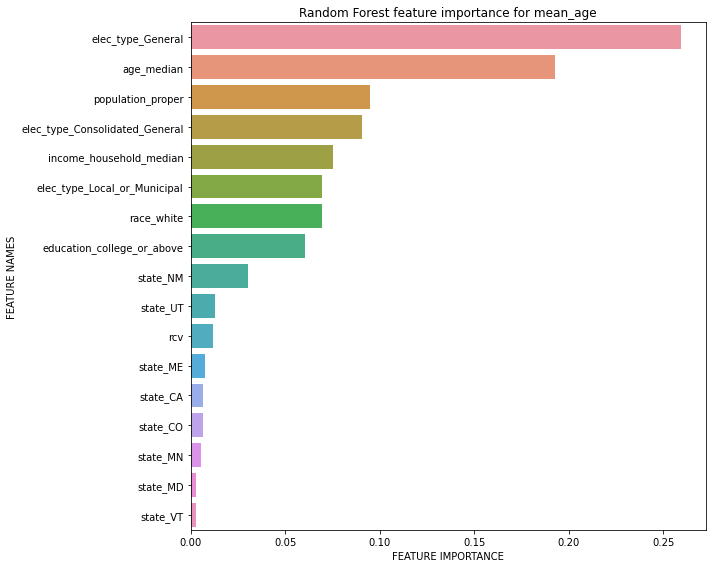

In [57]:
best_params_mean_age = train(df_mean_age, 'mean_age')
print(best_params_mean_age)

### 3.1 Linear Regression

In [58]:
train_lrg_sm(df_mean_age, 'mean_age') 

(284, 17)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     67.89
Date:                Sat, 26 Nov 2022   Prob (F-statistic):           4.97e-82
Time:                        16:23:17   Log-Likelihood:                -581.66
No. Observations:                 284   AIC:                             1195.
Df Residuals:                     268   BIC:                             1254.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,1.449656,1.532804
1,Mean_Squared_Error,3.519451,3.275836
2,R_squared_score,0.791649,0.715002


In [59]:
df_mean_age.drop(columns = 'rcv', inplace= True)
train_lrg_sm(df_mean_age, 'mean_age') 

(284, 16)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     68.70
Date:                Sat, 26 Nov 2022   Prob (F-statistic):           3.26e-80
Time:                        16:23:17   Log-Likelihood:                -577.96
No. Observations:                 284   AIC:                             1186.
Df Residuals:                     269   BIC:                             1241.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,1.477813,1.486307
1,Mean_Squared_Error,3.429059,3.819239
2,R_squared_score,0.781454,0.752894


## 4. Predict Income < 50K

In [60]:
df_income_under_50k = get_cols_model(voter_df, cities, 'perc_turnout_under_50k')                      
df_income_under_50k.head()

,rcv,Residence_Addresses_City,perc_turnout_under_50k,population_proper,age_median,income_household_median,education_college_or_above,race_white,elec_type_Consolidated_General,elec_type_General,elec_type_Local_or_Municipal,state_CA,state_CO,state_MD,state_ME,state_MN,state_NM,state_UT,state_VT
0,0.0,Adelphi,0.474739,15898,33.9,68064,32.3,17.2,0,1,0,0,0,1,0,0,0,0,0
1,0.0,Alamogordo,0.489294,31248,37.0,45531,20.1,79.1,0,1,0,0,0,0,0,0,1,0,0
2,0.0,Alamogordo,0.110822,31248,37.0,45531,20.1,79.1,0,0,1,0,0,0,0,0,1,0,0
3,0.0,Alamosa,0.306489,9871,27.3,32785,25.3,83.4,1,0,0,0,1,0,0,0,0,0,0
4,0.0,Alamosa,0.539032,9871,27.3,32785,25.3,83.4,0,1,0,0,1,0,0,0,0,0,0


### 4.1 Random Forest

perc_turnout_under_50k
train: (284, 17) (284,)
test: (71, 17) (71,)
Fitting 5 folds for each of 45 candidates, totalling 225 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.86305998 0.87950017 0.88608501 0.86908156 0.88597685 0.88896179
 0.86276514 0.87065862 0.87565562        nan        nan        nan
        nan        nan        nan 0.73610671 0.64721047 0.63436495
 0.76663347 0.7639338  0.76894407 0.76075976 0.76947697 0.77462707
        nan        nan        nan        nan        nan        nan
 0.80277275 0.75920578 0.75478865 0.82011933 0.82694703 0.82603159
 0.82013317 0.82472837 0.82713913        nan        nan        nan
        nan        nan        nan]
  warnings.warn(



Best params after cv: {'max_depth': None, 'max_features': 8, 'n_estimators': 100} 

Train
Mean Absolute Error: 0.02
Mean Squared Error: 0.001
R-squared scores: 0.985

Test
Mean Absolute Error: 0.054
Mean Squared Error: 0.005
R-squared scores: 0.895
                metric  rf_train   rf_test
0  Mean_Absolute_Error  0.019588  0.053784
1   Mean_Squared_Error  0.000631  0.004842
2      R_squared_score  0.985373  0.894606


Feature 0 (elec_type_General) importance: 0.431258734199017
Feature 1 (elec_type_Consolidated_General) importance: 0.15482363948544434
Feature 2 (elec_type_Local_or_Municipal) importance: 0.11674637242275852
Feature 3 (race_white) importance: 0.06709170311178078
Feature 4 (income_household_median) importance: 0.06545273168018934
Feature 5 (education_college_or_above) importance: 0.047159638021210204
Feature 6 (age_median) importance: 0.03419330117923098
Feature 7 (population_proper) importance: 0.021331354824696107
Feature 8 (state_CO) importance: 0.01735163901666796
Fe

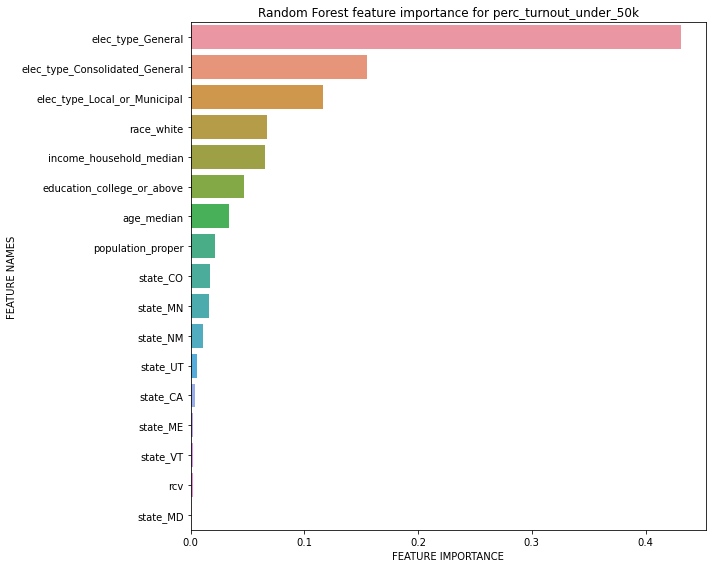

In [61]:
best_params_income_under_50k = train(df_income_under_50k, 'perc_turnout_under_50k')
print(best_params_income_under_50k)

### 4.1 Linear Regression

In [62]:
train_lrg_sm(df_income_under_50k, 'perc_turnout_under_50k') 

(284, 17)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     119.0
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          5.78e-109
Time:                        16:23:27   Log-Likelihood:                 332.42
No. Observations:                 284   AIC:                            -632.8
Df Residuals:                     268   BIC:                            -574.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.058870,0.058730
1,Mean_Squared_Error,0.005634,0.005377
2,R_squared_score,0.869431,0.880994


In [63]:
df_income_under_50k.drop(columns = 'state_VT', inplace= True)
train_lrg_sm(df_income_under_50k, 'perc_turnout_under_50k') 

(284, 16)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     127.0
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          2.81e-112
Time:                        16:23:28   Log-Likelihood:                 334.26
No. Observations:                 284   AIC:                            -636.5
Df Residuals:                     268   BIC:                            -578.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.059091,0.063313
1,Mean_Squared_Error,0.005562,0.005981
2,R_squared_score,0.876706,0.839614


In [64]:
df_income_under_50k.drop(columns = 'state_MD', inplace= True)
train_lrg_sm(df_income_under_50k, 'perc_turnout_under_50k') 

(284, 15)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     132.5
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          8.31e-112
Time:                        16:23:28   Log-Likelihood:                 335.88
No. Observations:                 284   AIC:                            -641.8
Df Residuals:                     269   BIC:                            -587.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.057525,0.063640
1,Mean_Squared_Error,0.005499,0.005965
2,R_squared_score,0.873377,0.866774


In [65]:
df_income_under_50k.drop(columns = 'state_CA', inplace= True)
train_lrg_sm(df_income_under_50k, 'perc_turnout_under_50k') 

(284, 14)
(284,)


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     143.9
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          4.11e-113
Time:                        16:23:28   Log-Likelihood:                 332.99
No. Observations:                 284   AIC:                            -638.0
Df Residuals:                     270   BIC:                            -586.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.058337,0.060135
1,Mean_Squared_Error,0.005612,0.005559
2,R_squared_score,0.873851,0.862504


In [66]:
df_income_under_50k.drop(columns = 'state_ME', inplace= True)
train_lrg_sm(df_income_under_50k, 'perc_turnout_under_50k') 

(284, 13)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     175.4
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          4.19e-120
Time:                        16:23:28   Log-Likelihood:                 347.91
No. Observations:                 284   AIC:                            -669.8
Df Residuals:                     271   BIC:                            -622.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.055703,0.069297
1,Mean_Squared_Error,0.005052,0.007849
2,R_squared_score,0.885913,0.810356


In [67]:
df_income_under_50k.drop(columns = 'race_white', inplace= True)
train_lrg_sm(df_income_under_50k, 'perc_turnout_under_50k') 

(284, 12)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     176.9
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          5.22e-117
Time:                        16:23:28   Log-Likelihood:                 340.83
No. Observations:                 284   AIC:                            -657.7
Df Residuals:                     272   BIC:                            -613.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.058590,0.074315
1,Mean_Squared_Error,0.005310,0.008486
2,R_squared_score,0.877368,0.812764


In [68]:
df_income_under_50k.drop(columns = 'education_college_or_above', inplace= True)
train_lrg_sm(df_income_under_50k, 'perc_turnout_under_50k') 

(284, 11)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     167.5
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          2.82e-110
Time:                        16:23:28   Log-Likelihood:                 318.92
No. Observations:                 284   AIC:                            -615.8
Df Residuals:                     273   BIC:                            -575.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.063230,0.063602
1,Mean_Squared_Error,0.006196,0.005883
2,R_squared_score,0.859829,0.857287


In [69]:
df_income_under_50k.drop(columns = 'income_household_median', inplace= True)
train_lrg_sm(df_income_under_50k, 'perc_turnout_under_50k') 

(284, 10)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)



(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     166.7
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.12e-105
Time:                        16:23:28   Log-Likelihood:                 306.87
No. Observations:                 284   AIC:                            -593.7
Df Residuals:                     274   BIC:                            -557.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
cons

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.065816,0.071260
1,Mean_Squared_Error,0.006745,0.008341
2,R_squared_score,0.845550,0.807949


In [70]:
df_income_under_50k.drop(columns = 'rcv', inplace= True)
train_lrg_sm(df_income_under_50k, 'perc_turnout_under_50k') 

(284, 9)
(284,)


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     177.4
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          7.06e-104
Time:                        16:23:28   Log-Likelihood:                 300.90
No. Observations:                 284   AIC:                            -583.8
Df Residuals:                     275   BIC:                            -551.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.066824,0.071894
1,Mean_Squared_Error,0.007035,0.007379
2,R_squared_score,0.837691,0.837364


In [71]:
df_income_under_50k.drop(columns = 'population_proper', inplace= True)
train_lrg_sm(df_income_under_50k, 'perc_turnout_under_50k') 

(284, 8)
(284,)


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     189.0
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          2.25e-101
Time:                        16:23:29   Log-Likelihood:                 295.45
No. Observations:                 284   AIC:                            -574.9
Df Residuals:                     276   BIC:                            -545.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.068034,0.066882
1,Mean_Squared_Error,0.007310,0.006451
2,R_squared_score,0.827390,0.865992


## 5. Predict Income > 100K

In [72]:
df_income_over_100k = get_cols_model(voter_df, cities, 'perc_turnout_over_100k')      
df_income_over_100k.head()

,rcv,Residence_Addresses_City,perc_turnout_over_100k,population_proper,age_median,income_household_median,education_college_or_above,race_white,elec_type_Consolidated_General,elec_type_General,elec_type_Local_or_Municipal,state_CA,state_CO,state_MD,state_ME,state_MN,state_NM,state_UT,state_VT
0,0.0,Adelphi,0.501815,15898,33.9,68064,32.3,17.2,0,1,0,0,0,1,0,0,0,0,0
1,0.0,Alamogordo,0.554673,31248,37.0,45531,20.1,79.1,0,1,0,0,0,0,0,0,1,0,0
2,0.0,Alamogordo,0.138876,31248,37.0,45531,20.1,79.1,0,0,1,0,0,0,0,0,1,0,0
3,0.0,Alamosa,0.432444,9871,27.3,32785,25.3,83.4,1,0,0,0,1,0,0,0,0,0,0
4,0.0,Alamosa,0.687079,9871,27.3,32785,25.3,83.4,0,1,0,0,1,0,0,0,0,0,0


### 5.1 Random Forest

perc_turnout_over_100k
train: (284, 17) (284,)
test: (71, 17) (71,)
Fitting 5 folds for each of 45 candidates, totalling 225 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.91148988 0.92350056 0.92608147 0.92779687 0.93584766 0.93694672
 0.93030389 0.9310129  0.93170116        nan        nan        nan
        nan        nan        nan 0.81183075 0.72032767 0.7035835
 0.86518916 0.8621653  0.86602376 0.88761572 0.88596452 0.88617331
        nan        nan        nan        nan        nan        nan
 0.87231299 0.81805505 0.81850418 0.89598105 0.90230065 0.90329475
 0.90930511 0.90887655 0.90955973        nan        nan        nan
        nan        nan        nan]
  warnings.warn(



Best params after cv: {'max_depth': None, 'max_features': 8, 'n_estimators': 100} 

Train
Mean Absolute Error: 0.015
Mean Squared Error: 0.0
R-squared scores: 0.991

Test
Mean Absolute Error: 0.043
Mean Squared Error: 0.003
R-squared scores: 0.935
                metric  rf_train   rf_test
0  Mean_Absolute_Error  0.015050  0.042828
1   Mean_Squared_Error  0.000371  0.002940
2      R_squared_score  0.991187  0.934857


Feature 0 (elec_type_General) importance: 0.5375500746326263
Feature 1 (elec_type_Consolidated_General) importance: 0.18933518094840598
Feature 2 (elec_type_Local_or_Municipal) importance: 0.09412684704223886
Feature 3 (state_CO) importance: 0.0348756145390428
Feature 4 (education_college_or_above) importance: 0.03298581857536067
Feature 5 (race_white) importance: 0.02832902609566346
Feature 6 (age_median) importance: 0.018590034526327605
Feature 7 (state_MN) importance: 0.016147998031073113
Feature 8 (income_household_median) importance: 0.013363068864316076
Feature 9 (

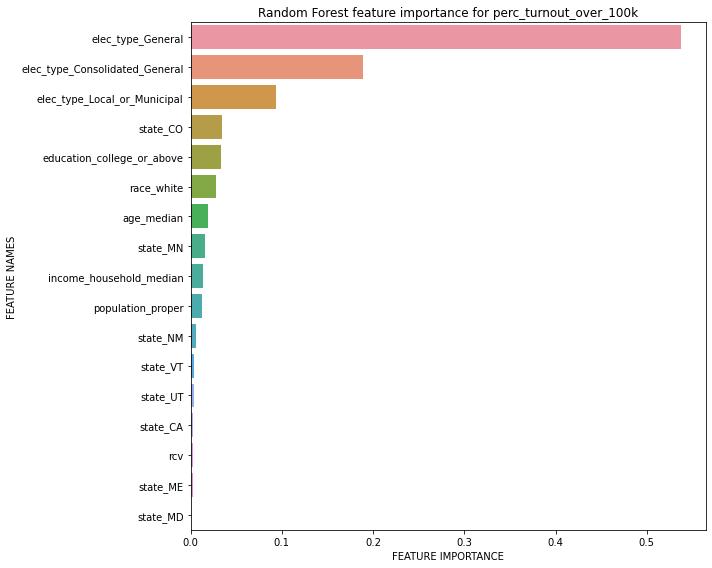

In [73]:
best_params_income_over_100k = train(df_income_over_100k, 'perc_turnout_over_100k')
print(best_params_income_over_100k)

### 5.1 Linear Regression

In [74]:
train_lrg_sm(df_income_over_100k, 'perc_turnout_over_100k') 

(284, 17)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     211.8
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          6.05e-139
Time:                        16:23:40   Log-Likelihood:                 401.32
No. Observations:                 284   AIC:                            -770.6
Df Residuals:                     268   BIC:                            -712.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.048344,0.047237
1,Mean_Squared_Error,0.003468,0.003531
2,R_squared_score,0.922219,0.899343


In [75]:
df_income_over_100k.drop(columns = 'state_CA', inplace= True)
train_lrg_sm(df_income_over_100k, 'perc_turnout_over_100k') 

(284, 16)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     201.3
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          3.17e-136
Time:                        16:23:40   Log-Likelihood:                 403.13
No. Observations:                 284   AIC:                            -774.3
Df Residuals:                     268   BIC:                            -715.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.046212,0.051914
1,Mean_Squared_Error,0.003425,0.003675
2,R_squared_score,0.918482,0.916380


In [76]:
df_income_over_100k.drop(columns = 'state_MD', inplace= True)
train_lrg_sm(df_income_over_100k, 'perc_turnout_over_100k') 

(284, 15)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     223.3
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          4.71e-139
Time:                        16:23:40   Log-Likelihood:                 402.83
No. Observations:                 284   AIC:                            -775.7
Df Residuals:                     269   BIC:                            -720.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.048170,0.048186
1,Mean_Squared_Error,0.003432,0.003814
2,R_squared_score,0.920764,0.904492


In [77]:
df_income_over_100k.drop(columns = 'state_ME', inplace= True)
train_lrg_sm(df_income_over_100k, 'perc_turnout_over_100k') 

(284, 14)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     241.2
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          3.15e-140
Time:                        16:23:40   Log-Likelihood:                 405.30
No. Observations:                 284   AIC:                            -782.6
Df Residuals:                     270   BIC:                            -731.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.047161,0.051732
1,Mean_Squared_Error,0.003372,0.004097
2,R_squared_score,0.920729,0.905133


In [78]:
df_income_over_100k.drop(columns = 'race_white', inplace= True)
train_lrg_sm(df_income_over_100k, 'perc_turnout_over_100k') 

(284, 13)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     243.4
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          2.05e-137
Time:                        16:23:40   Log-Likelihood:                 400.54
No. Observations:                 284   AIC:                            -775.1
Df Residuals:                     271   BIC:                            -727.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.047197,0.054022
1,Mean_Squared_Error,0.003488,0.004529
2,R_squared_score,0.915089,0.907885


In [79]:
df_income_over_100k.drop(columns = 'education_college_or_above', inplace= True)
train_lrg_sm(df_income_over_100k, 'perc_turnout_over_100k') 

(284, 12)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     240.5
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          3.96e-133
Time:                        16:23:40   Log-Likelihood:                 379.88
No. Observations:                 284   AIC:                            -735.8
Df Residuals:                     272   BIC:                            -692.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.050222,0.065364
1,Mean_Squared_Error,0.004034,0.006146
2,R_squared_score,0.906760,0.843845


In [80]:
df_income_over_100k.drop(columns = 'rcv', inplace= True)
train_lrg_sm(df_income_over_100k, 'perc_turnout_over_100k') 

(284, 11)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     233.4
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.75e-127
Time:                        16:23:40   Log-Likelihood:                 364.94
No. Observations:                 284   AIC:                            -707.9
Df Residuals:                     273   BIC:                            -667.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.053482,0.056308
1,Mean_Squared_Error,0.004481,0.004595
2,R_squared_score,0.895265,0.890556


In [81]:
df_income_over_100k.drop(columns = 'population_proper', inplace= True)
train_lrg_sm(df_income_over_100k, 'perc_turnout_over_100k') 

(284, 10)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     265.1
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.10e-129
Time:                        16:23:41   Log-Likelihood:                 363.94
No. Observations:                 284   AIC:                            -707.9
Df Residuals:                     274   BIC:                            -671.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.053061,0.055962
1,Mean_Squared_Error,0.004513,0.004588
2,R_squared_score,0.896984,0.877486


In [82]:
df_income_over_100k.drop(columns = 'state_NM', inplace= True)
train_lrg_sm(df_income_over_100k, 'perc_turnout_over_100k') 

(284, 9)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     291.5
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.59e-129
Time:                        16:23:41   Log-Likelihood:                 362.52
No. Observations:                 284   AIC:                            -707.0
Df Residuals:                     275   BIC:                            -674.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.053850,0.053021
1,Mean_Squared_Error,0.004558,0.004667
2,R_squared_score,0.894514,0.884492


In [83]:
df_income_over_100k.drop(columns = 'income_household_median', inplace= True)
train_lrg_sm(df_income_over_100k, 'perc_turnout_over_100k') 

(284, 8)
(284,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     338.8
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.67e-131
Time:                        16:23:41   Log-Likelihood:                 363.12
No. Observations:                 284   AIC:                            -710.2
Df Residuals:                     276   BIC:                            -681.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,metric,linreg_train,linreg_test
0,Mean_Absolute_Error,0.053421,0.057588
1,Mean_Squared_Error,0.004539,0.005019
2,R_squared_score,0.895743,0.871346
